In [2]:
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np
from snntorch import export
import nir

In [3]:
graph = nir.read('lif_norse.nir')
for nkey, node in graph.nodes.items():
    print(f"{nkey:7} {node}")

0       Affine(weight=array([[1.]], dtype=float32), bias=array([0.], dtype=float32))
1       LIF(tau=array([0.0025], dtype=float32), r=array([1.], dtype=float32), v_leak=array([0.], dtype=float32), v_threshold=array([0.1], dtype=float32))
input   Input(input_type={'input': array([1])})
output  Output(output_type={'output': array([1])})


In [4]:
isis = [
    6, 15, 4, 3, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 14
]
d1 = list(np.concatenate([isi*[0]+[1] for isi in isis]))[:100]
d = np.array([[e] + 9*[0] for e in d1]).reshape(1, -1)

In [5]:
class NIRNetwork(torch.nn.Module):
    def __init__(self, graph: nir.ir.NIRGraph) -> None:
        super().__init__()

        nirlif = graph.nodes['1']
        niraffine = graph.nodes['0']

        dt = 1e-4

        beta = 1-(dt/nirlif.tau)
        assert nirlif.v_leak == 0., "snnTorch doesn't support v_leak"
        vthr = nirlif.v_threshold

        w_scale = nirlif.r * dt / nirlif.tau
        weights = niraffine.weight * w_scale
        nonzero_bias = np.alltrue(niraffine.bias == 0.)

        print(f'NIR net with beta: {beta}, v_thr: {vthr}, w_scale: {w_scale}')

        self.lin = nn.Linear(1, 1, bias=nonzero_bias)
        self.lin.weight.data = torch.Tensor(weights)
        if nonzero_bias:
            # TODO: how to scale this?
            self.lin.bias.data = torch.Tensor(niraffine.bias)

        self.lif = snn.Leaky(beta=beta, threshold=vthr, reset_mechanism='zero')
    
    def forward(self, ut: torch.Tensor) -> torch.Tensor:
        # shape of ut: (N, T)
        spk_rec, mem_rec = [], []
        mem = torch.zeros((1,))  # self.lif.init_leaky()
        for t in range(ut.shape[1]):
            cur = self.lin(ut[:, t])
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk)
            mem_rec.append(mem)
        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

In [6]:
net = NIRNetwork(graph)
spk, mem = net(torch.Tensor(d))
mem.shape, spk.shape

NIR net with beta: [0.96], v_thr: [0.1], w_scale: [0.04]


/tmp/ipykernel_21232/2326313447.py:1: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  net = NIRNetwork(graph)


(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [8]:
mem[60:100]

tensor([[0.0400],
        [0.0384],
        [0.0369],
        [0.0354],
        [0.0340],
        [0.0326],
        [0.0313],
        [0.0301],
        [0.0289],
        [0.0277],
        [0.0266],
        [0.0255],
        [0.0245],
        [0.0235],
        [0.0226],
        [0.0217],
        [0.0208],
        [0.0200],
        [0.0192],
        [0.0184],
        [0.0177],
        [0.0170],
        [0.0163],
        [0.0156],
        [0.0150],
        [0.0144],
        [0.0138],
        [0.0133],
        [0.0128],
        [0.0122],
        [0.0118],
        [0.0113],
        [0.0108],
        [0.0104],
        [0.0100],
        [0.0096],
        [0.0092],
        [0.0088],
        [0.0085],
        [0.0081]], grad_fn=<SliceBackward0>)

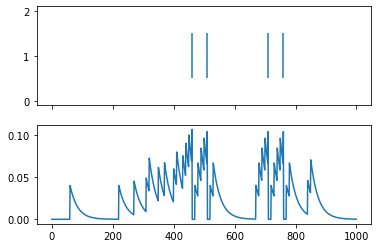

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].eventplot(np.where(spk.detach().numpy() == 1)[0])
axs[1].plot(mem.detach().numpy())
plt.show();

In [102]:
with open(f'lif_snntorch.csv', 'w') as fw:
    for idx in range(d.shape[1]):
        fw.write(f'{d[0, idx]},{mem.detach().numpy()[idx, 0]},{spk.detach().numpy()[idx, 0]}\n')

## saved for later

In [ ]:
class NIRNetwork(torch.nn.Module):
    def __init__(self, module_list: list) -> None:
        super().__init__()
        self.blocks = nn.ModuleList(module_list)
    
    def forward(self, ut: torch.Tensor) -> torch.Tensor:
        # shape of ut: (N, T)
        x = ut
        for block in self.blocks:
            if isinstance(block, nn.Linear):
            elif isinstance(block, snn.Leaky):
                out = []
                hid = None
                for t in range(ut.shape[1]):
                    
            else:
                raise NotImplementedError('unknown block')

    def forward(self, ut):
        # shape of ut: (N, T)

        hidden = {}
        for idx, block in enumerate(self.blocks):
            if isinstance(block, snn.Leaky):
                hidden[idx] = [block.init_leaky()]

        output = {idx: [] for idx in range(self.blocks)}
        for t in range(ut.shape[1]):
            for idx, block in enumerate(self.blocks):
                if isinstance(block, nn.Linear):
                elif isinstance(block, snn.Leaky):
                    x, hidden[]
                else:
                    raise NotImplementedError('unknown block')

        # # Initialize hidden states at t=0
        # mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()
        # # Record the final layer
        # spk2_rec = []
        # mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


In [ ]:


data_path = "untrained-snntorch.pt"

net = nn.Sequential(nn.Linear(784, 128),
                    snn.Leaky(beta=0.8, init_hidden=True),
                    nn.Linear(128, 10),
                    snn.Leaky(beta=0.8, init_hidden=True, output=True))

# save model in pt format
torch.save(net.state_dict(), data_path)

# load model (does nothing here, but shown for completeness)
net.load_state_dict(torch.load(data_path))

# generate input tensor to dynamically construct graph
x = torch.zeros(784)

# generate NIR graph
nir_net = export.to_nir(net, x)
